# Validity of using prescription records to identify patient comorbidities
## Analysis of COPD
## Sensitivity Analysis - ever diagnosed

**ReadMe:**
- This is a script used in the analysis for Schnier et al., 2025: Validity of using prescription records to classify disease – a record linkage study using routinely collected electronic health records from the UK.
- The underlying data set has been created using the Optimum Patient Care Research Database (https://opcrd.optimumpatientcare.org/). The authors do not have permission to give the public access to the study dataset; researchers may request access to OPCRD for their own purposes. 
 - All code is run in StataSE 18. 


**Set up:**
|Var|Input|
| --- | --- | 
|population|425,000|
|diagnostic codes|Jenni Quint|
|drug codes|Jenni Quint (excluding antibiotics)|
|sql date|25.06.2025|
|sql code|copdselection_20250622.sql| 

In [1]:
    clear all

### Import from SQL server and data wrangling

In [2]:
odbc load, exec("select * from [copd_425000_fullFU_20250622]") dsn("sqlserverconnect")

In [3]:
generate test=0 if missing(drug_dt)
replace test=1 if ! missing(drug_dt)  

generate diag=0 if missing(diag_dt)
replace diag=1 if ! missing(diag_dt)  

gen start_year=year(fu_start_dt)


egen agecat = cut(age), at(16,30,70,120)
label def agecat_lab 16 "Young" 30 "0Middle" 70 "Elderly" 120 "weird"
label values agecat agecat_lab

egen yearcat = cut(start_year), at(2004,2010,2016,2025)
label def yearcat_lab 2004 "2004-2009" 2010 "2010-2015" 2016 "2016-2020" 
label values yearcat yearcat_lab

egen imdcat = cut(imd_decile), at(0,4,8,11)
label def imdcat_lab 0 "1-3" 4 "4-7" 8 "8-10" 
label values imdcat imdcat_lab


replace bnf_code = "Adrenoreceptor agonist" if bnf_code== "030101"
replace bnf_code = "Antimuscarinic Bronchodilator" if bnf_code== "030102"
replace bnf_code = "Theophylline" if bnf_code== "030103"
replace bnf_code = "Compound bronchodilator" if bnf_code== "030104"
replace bnf_code = "Devices" if bnf_code== "030105" | bnf_code=="210102" | bnf_code=="211200"
replace bnf_code = "Corticosteroids" if bnf_code== "030200"
replace bnf_code = "Topical nasal decongestance" if bnf_code== "120202"
replace bnf_code = "Other/unknown" if missing(bnf_code) & ! missing(drug_dt)
replace bnf_code = "OCT" if bnf_code== "060302"



replace ethnicity="0white" if ethnicity=="1"
replace ethnicity="Other" if ethnicity=="2"
replace ethnicity="Other" if ethnicity=="3"
replace ethnicity="Other" if ethnicity=="4"
replace ethnicity="Other" if ethnicity=="5"
replace ethnicity="Missing" if ethnicity=="99"


encode bnf_code, generate(bnf_code_values) 
encode description, generate(description_values)
encode ethnicity, generate(ethnicity_values) 

gen diag_neg=diag==0
gen diag_pos=diag==1
encode region_name, generate(region) label(regionlbl)
encode ethnicity, generate(ethnic)


(74,041 missing values generated)
(74,041 real changes made)
(21,977 missing values generated)
(21,977 real changes made)
(2,589 missing values generated)
variable bnf_code was str6 now str22
(37,562 real changes made)
variable bnf_code was str22 now str29
(3,283 real changes made)
(198 real changes made)
(904 real changes made)
(0 real changes made)
(17,346 real changes made)
(0 real changes made)
(606 real changes made)
(14,137 real changes made)
variable ethnicity was str2 now str6
(257,981 real changes made)
(3,762 real changes made)
(23,912 real changes made)
(7,430 real changes made)
(8,764 real changes made)
variable ethnicity was str6 now str7
(123,151 real changes made)


(bin=19, start=16, width=5)


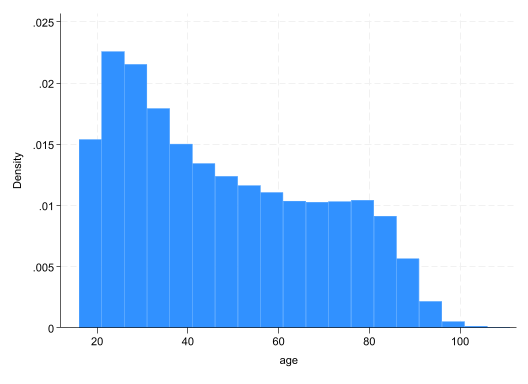

In [4]:
histogram age, width(5)


This table holds one randomly selected diagnostic code found during the observation period. The table is truncated to only include diagnostic codes with a count of 10 or more.

In [5]:
set linesize 132
groups description , select(f >= 10) ord(h) table 


  +-----------------------------------------------------------------------------------------------------+
  |                                                               description   Freq.   Percent     %<= |
  |-----------------------------------------------------------------------------------------------------|
  |                     other specified chronic obstructive pulmonary disease    4697     21.37   21.37 |
  |                                               chr. airway obstruction nos    4207     19.14   40.52 |
  |                                                            bronchitis nos    1832      8.34   48.85 |
  |                                                    Bronchitis unspecified    1303      5.93   54.78 |
  |                       Chronic obstructive pulmonary disease annual review     925      4.21   58.99 |
  |-----------------------------------------------------------------------------------------------------|
  |                       chronic obstructive

These tables holds one randomly selected prescrption during the observation period. The table is truncated to only include codes with a count of 10 or more.


In [6]:
set linesize 132
groups bnf_code , select(f >= 10) ord(h) table 


  +---------------------------------------------------------+
  |                      bnf_code   Freq.   Percent     %<= |
  |---------------------------------------------------------|
  |        Adrenoreceptor agonist   37562     50.73   50.73 |
  |               Corticosteroids   17346     23.43   74.16 |
  |                           OCT   14137     19.09   93.25 |
  | Antimuscarinic Bronchodilator    3283      4.43   97.69 |
  |       Compound bronchodilator     904      1.22   98.91 |
  |---------------------------------------------------------|
  |                 Other/unknown     606      0.82   99.73 |
  |                  Theophylline     198      0.27   99.99 |
  +---------------------------------------------------------+


### Results
#### Overall

In [7]:
diagt diag test


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    17,865      4,112 |    21,977 
    Normal |    56,176    346,847 |   403,023 
-----------+----------------------+----------
     Total |    74,041    350,959 |   425,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.2%      5.1%       5.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     81.3%     80.8%     81.8%
Specificity                      Pr(-|N)     86.1%     86.0%     86.2%
ROC area               (Sens. + Spec.)/2      0.84      0.83      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.83      5.

#### Males

In [8]:
diagt diag test if sex==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     9,320      2,121 |    11,441 
    Normal |    23,016    173,828 |   196,844 
-----------+----------------------+----------
     Total |    32,336    175,949 |   208,285 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.5%      5.4%       5.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     81.5%     80.7%     82.2%
Specificity                      Pr(-|N)     88.3%     88.2%     88.4%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.97      6.

#### Females

In [9]:
diagt diag test if sex==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     8,544      1,991 |    10,535 
    Normal |    33,160    173,011 |   206,171 
-----------+----------------------+----------
     Total |    41,704    175,002 |   216,706 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.9%      4.8%       5.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     81.1%     80.3%     81.8%
Specificity                      Pr(-|N)     83.9%     83.8%     84.1%
ROC area               (Sens. + Spec.)/2      0.83      0.82      0.83 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.04      4.

#### Age
*16-29*

In [10]:
diagt diag test if agecat==16


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       204        472 |       676 
    Normal |    12,779    104,219 |   116,998 
-----------+----------------------+----------
     Total |    12,983    104,691 |   117,674 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.6%      0.5%       0.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     30.2%     26.7%     33.8%
Specificity                      Pr(-|N)     89.1%     88.9%     89.3%
ROC area               (Sens. + Spec.)/2      0.60      0.58      0.61 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      2.76      2.

*30-69*

In [11]:
diagt diag test if agecat==30


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,795      1,864 |     9,659 
    Normal |    29,601    182,135 |   211,736 
-----------+----------------------+----------
     Total |    37,396    183,999 |   221,395 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.4%      4.3%       4.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     80.7%     79.9%     81.5%
Specificity                      Pr(-|N)     86.0%     85.9%     86.2%
ROC area               (Sens. + Spec.)/2      0.83      0.83      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.77      5.

In [12]:
diagt diag test if agecat==70


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     9,866      1,776 |    11,642 
    Normal |    13,796     60,493 |    74,289 
-----------+----------------------+----------
     Total |    23,662     62,269 |    85,931 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)     13.5%     13.3%      13.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     84.7%     84.1%     85.4%
Specificity                      Pr(-|N)     81.4%     81.1%     81.7%
ROC area               (Sens. + Spec.)/2      0.83      0.83      0.83 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.56      4.

#### Year at start of oberservation period 
*2004-2009*

In [13]:
diagt diag test if yearcat==2004


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,167      1,658 |     8,825 
    Normal |    20,393    120,782 |   141,175 
-----------+----------------------+----------
     Total |    27,560    122,440 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.9%      5.8%       6.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     81.2%     80.4%     82.0%
Specificity                      Pr(-|N)     85.6%     85.4%     85.7%
ROC area               (Sens. + Spec.)/2      0.83      0.83      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.62      5.

*2010-2015*

In [14]:
diagt diag test if yearcat==2010


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,119      1,333 |     7,452 
    Normal |    20,223    122,325 |   142,548 
-----------+----------------------+----------
     Total |    26,342    123,658 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.0%      4.9%       5.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     82.1%     81.2%     83.0%
Specificity                      Pr(-|N)     85.8%     85.6%     86.0%
ROC area               (Sens. + Spec.)/2      0.84      0.84      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.79      5.

*2016-2020*

In [15]:
diagt diag test if yearcat==2016


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,579      1,121 |     5,700 
    Normal |    15,560    103,740 |   119,300 
-----------+----------------------+----------
     Total |    20,139    104,861 |   125,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.6%      4.4%       4.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     80.3%     79.3%     81.4%
Specificity                      Pr(-|N)     87.0%     86.8%     87.1%
ROC area               (Sens. + Spec.)/2      0.84      0.83      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.16      6.

#### IMD of practice
*1-3*

In [16]:
diagt diag test if imdcat==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,122      1,566 |     8,688 
    Normal |    19,536    126,327 |   145,863 
-----------+----------------------+----------
     Total |    26,658    127,893 |   154,551 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.6%      5.5%       5.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     82.0%     81.2%     82.8%
Specificity                      Pr(-|N)     86.6%     86.4%     86.8%
ROC area               (Sens. + Spec.)/2      0.84      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.12      6.

*4-7*

In [17]:
diagt diag test if imdcat==4


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,122      1,224 |     7,346 
    Normal |    20,069    115,630 |   135,699 
-----------+----------------------+----------
     Total |    26,191    116,854 |   143,045 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.1%      5.0%       5.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     83.3%     82.5%     84.2%
Specificity                      Pr(-|N)     85.2%     85.0%     85.4%
ROC area               (Sens. + Spec.)/2      0.84      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.63      5.

*8-10*

In [18]:
diagt diag test if imdcat==8


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,594      1,319 |     5,913 
    Normal |    16,363    102,539 |   118,902 
-----------+----------------------+----------
     Total |    20,957    103,858 |   124,815 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.7%      4.6%       4.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     77.7%     76.6%     78.7%
Specificity                      Pr(-|N)     86.2%     86.0%     86.4%
ROC area               (Sens. + Spec.)/2      0.82      0.81      0.83 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.65      5.

#### Commissioning Regions
EAST OF ENGLAND

In [19]:
diagt diag test if regexm(region_name,"ENGLAND")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,775        561 |     4,336 
    Normal |    13,726     71,575 |    85,301 
-----------+----------------------+----------
     Total |    17,501     72,136 |    89,637 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.8%      4.7%       5.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     87.1%     86.0%     88.0%
Specificity                      Pr(-|N)     83.9%     83.7%     84.2%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.41      5.

London

In [20]:
diagt diag test if regexm(region_name,"LONDON")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       310        110 |       420 
    Normal |     1,659     14,646 |    16,305 
-----------+----------------------+----------
     Total |     1,969     14,756 |    16,725 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.5%      2.3%       2.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     73.8%     69.3%     78.0%
Specificity                      Pr(-|N)     89.8%     89.4%     90.3%
ROC area               (Sens. + Spec.)/2      0.82      0.80      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.25      6.

Midlands

In [21]:
diagt diag test if regexm(region_name,"MID")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,499        597 |     3,096 
    Normal |     6,739     36,708 |    43,447 
-----------+----------------------+----------
     Total |     9,238     37,305 |    46,543 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.7%      6.4%       6.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     80.7%     79.3%     82.1%
Specificity                      Pr(-|N)     84.5%     84.1%     84.8%
ROC area               (Sens. + Spec.)/2      0.83      0.82      0.83 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.20      5.

Yorkshire

In [22]:
diagt diag test if regexm(region_name,"YORK")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,932        803 |     4,735 
    Normal |    10,863     70,513 |    81,376 
-----------+----------------------+----------
     Total |    14,795     71,316 |    86,111 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.5%      5.3%       5.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     83.0%     81.9%     84.1%
Specificity                      Pr(-|N)     86.7%     86.4%     86.9%
ROC area               (Sens. + Spec.)/2      0.85      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.22      6.

North West

In [23]:
diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,067        486 |     2,553 
    Normal |     5,634     39,406 |    45,040 
-----------+----------------------+----------
     Total |     7,701     39,892 |    47,593 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.4%      5.2%       5.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     81.0%     79.4%     82.5%
Specificity                      Pr(-|N)     87.5%     87.2%     87.8%
ROC area               (Sens. + Spec.)/2      0.84      0.83      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.47      6.

South East

In [24]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,080        993 |     4,073 
    Normal |    10,918     75,494 |    86,412 
-----------+----------------------+----------
     Total |    13,998     76,487 |    90,485 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.5%      4.4%       4.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     75.6%     74.3%     76.9%
Specificity                      Pr(-|N)     87.4%     87.1%     87.6%
ROC area               (Sens. + Spec.)/2      0.81      0.81      0.82 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.99      5.

South West

In [25]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,777        431 |     2,208 
    Normal |     5,058     28,910 |    33,968 
-----------+----------------------+----------
     Total |     6,835     29,341 |    36,176 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.1%      5.9%       6.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     80.5%     78.8%     82.1%
Specificity                      Pr(-|N)     85.1%     84.7%     85.5%
ROC area               (Sens. + Spec.)/2      0.83      0.82      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.40      5.

#### System
SystmOne

In [26]:
diagt diag test if regexm(system,"One")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    10,378      1,611 |    11,989 
    Normal |    32,193    184,573 |   216,766 
-----------+----------------------+----------
     Total |    42,571    186,184 |   228,755 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.2%      5.2%       5.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     86.6%     85.9%     87.2%
Specificity                      Pr(-|N)     85.1%     85.0%     85.3%
ROC area               (Sens. + Spec.)/2      0.86      0.86      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.83      5.

Vision

In [27]:
diagt diag test if regexm(system,"Vision")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       548        168 |       716 
    Normal |     1,874     11,154 |    13,028 
-----------+----------------------+----------
     Total |     2,422     11,322 |    13,744 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.2%      4.8%       5.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     76.5%     73.3%     79.6%
Specificity                      Pr(-|N)     85.6%     85.0%     86.2%
ROC area               (Sens. + Spec.)/2      0.81      0.79      0.83 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.32      5.

EMIS

In [28]:
diagt diag test if regexm(ustrupper(system),"EMIS")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,917      2,333 |     9,250 
    Normal |    22,055    151,060 |   173,115 
-----------+----------------------+----------
     Total |    28,972    153,393 |   182,365 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.1%      5.0%       5.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     74.8%     73.9%     75.7%
Specificity                      Pr(-|N)     87.3%     87.1%     87.4%
ROC area               (Sens. + Spec.)/2      0.81      0.81      0.81 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.87      5.

#### RA_Index
Index==1

In [29]:
diagt diag test if RA_index==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    13,304      3,220 |    16,524 
    Normal |    41,106    264,067 |   305,173 
-----------+----------------------+----------
     Total |    54,410    267,287 |   321,697 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.1%      5.1%       5.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     80.5%     79.9%     81.1%
Specificity                      Pr(-|N)     86.5%     86.4%     86.7%
ROC area               (Sens. + Spec.)/2      0.84      0.83      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.98      5.

Index==0

In [30]:
diagt diag test if RA_index==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,561        892 |     5,453 
    Normal |    15,070     82,780 |    97,850 
-----------+----------------------+----------
     Total |    19,631     83,672 |   103,303 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.3%      5.1%       5.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     83.6%     82.6%     84.6%
Specificity                      Pr(-|N)     84.6%     84.4%     84.8%
ROC area               (Sens. + Spec.)/2      0.84      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.43      5.

#### Ethnicity
Ethnicity==0000white

In [31]:
diagt diag test if ethnicity=="0white"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    13,617      2,801 |    16,418 
    Normal |    38,749    202,814 |   241,563 
-----------+----------------------+----------
     Total |    52,366    205,615 |   257,981 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.4%      6.3%       6.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     82.9%     82.4%     83.5%
Specificity                      Pr(-|N)     84.0%     83.8%     84.1%
ROC area               (Sens. + Spec.)/2      0.83      0.83      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.17      5.

In [32]:
diagt diag test if ethnicity=="Other"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       514        207 |       721 
    Normal |     4,912     38,235 |    43,147 
-----------+----------------------+----------
     Total |     5,426     38,442 |    43,868 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.6%      1.5%       1.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     71.3%     67.8%     74.6%
Specificity                      Pr(-|N)     88.6%     88.3%     88.9%
ROC area               (Sens. + Spec.)/2      0.80      0.78      0.82 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.26      5.

In [33]:
diagt diag test if ethnicity=="Missing"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,734      1,104 |     4,838 
    Normal |    12,515    105,798 |   118,313 
-----------+----------------------+----------
     Total |    16,249    106,902 |   123,151 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.9%      3.8%       4.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     77.2%     76.0%     78.4%
Specificity                      Pr(-|N)     89.4%     89.2%     89.6%
ROC area               (Sens. + Spec.)/2      0.83      0.83      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.30      7.

In [34]:
tempname memhold
postfile `memhold' str20 var prev sens spec ppv npv roc using "validity.dta",replace

quietly diagt diag test
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("all") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Male") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Female") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==16
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age young") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==30
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age middle") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==70
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age elderly") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if yearcat==2004
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2004-2009") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if yearcat==2010
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2010-2015") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc')

quietly diagt diag test if yearcat==2016
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2016-2020") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if imdcat==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 1,3") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==4
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 4,7") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==8
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 8,10") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if regexm(region_name,"LONDON")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("London") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"MID")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Midlands") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"YORK")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Yorkshire") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("North West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South East") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"One")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("SystemOne") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"Vision")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Vision") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(ustrupper(system),"EMIS")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("EMIS") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex1") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex0") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="0white"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_0white") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="Other"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Other") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 



quietly diagt diag test if ethnicity=="Missing"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Missing") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

postclose `memhold'

### Logistic Regression
#### PPV

In [35]:
drop if missing(imdcat)
drop if missing(sex)

(2,589 observations deleted)
(9 observations deleted)


In [36]:
logistic diag_pos if test==1


Logistic regression                                     Number of obs = 73,805
                                                        LR chi2(0)    =   0.00
                                                        Prob > chi2   =      .
Log likelihood = -40814.587                             Pseudo R2     = 0.0000

------------------------------------------------------------------------------
    diag_pos |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |      .3187   .0027403  -132.99   0.000     .3133741    .3241163
------------------------------------------------------------------------------


In [37]:
logistic diag_pos i.bnf_code_values if test==1

note: 1.bnf_code_values != 0 predicts success perfectly;
      1.bnf_code_values omitted and 1 obs not used.

note: 2.bnf_code_values != 0 predicts failure perfectly;
      2.bnf_code_values omitted and 4 obs not used.

note: 9.bnf_code_values omitted because of collinearity.

Logistic regression                                    Number of obs =  73,800
                                                       LR chi2(6)    = 8102.02
                                                       Prob > chi2   =  0.0000
Log likelihood = -36761.051                            Pseudo R2     =  0.0993

------------------------------------------------------------------------------------------------
                      diag_pos | Odds ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------------------------+----------------------------------------------------------------
               bnf_code_values |
                       030303  |          1  (empty)
                       10010

In [38]:
gen newdiag=diag_pos

melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model1


Fitting fixed-effects model:

Iteration 0:  Log likelihood = -35934.799  
Iteration 1:  Log likelihood = -35256.849  
Iteration 2:  Log likelihood = -35210.992  
Iteration 3:  Log likelihood = -35210.955  
Iteration 4:  Log likelihood = -35210.955  

Refining starting values:

Grid node 0:  Log likelihood = -35087.909

Fitting full model:

Iteration 0:  Log likelihood = -35087.909  (not concave)
Iteration 1:  Log likelihood =  -34962.39  (not concave)
Iteration 2:  Log likelihood = -34919.759  
Iteration 3:  Log likelihood = -34915.269  
Iteration 4:  Log likelihood =  -34913.42  
Iteration 5:  Log likelihood = -34913.418  

Mixed-effects logistic regression               Number of obs     =     73,570
Group variable: practice_id                     Number of groups  =        333

                                                Obs per group:
                                                              min =          1
                                                              avg

##### Likelihood ratio tests

In [39]:


quietly: melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic if test==1 || practice_id:,or
estimates store model_imd

quietly:melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.imdcat if test==1 || practice_id:,or
estimates store model_ethnicity

quietly:melogit newdiag i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_sex

quietly:melogit newdiag i.sex i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_year

quietly: melogit newdiag i.sex i.yearcat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_age



In [40]:
lrtest model1 model_sex
lrtest model1 model_year
lrtest model1 model_age
lrtest model1 model_ethnicity
lrtest model1 model_imd



Likelihood-ratio test
Assumption: model_sex nested within model1

 LR chi2(1) = 658.00
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_year nested within model1

 LR chi2(2) =   8.84
Prob > chi2 = 0.0121

Likelihood-ratio test
Assumption: model_age nested within model1

 LR chi2(2) = 8619.11
Prob > chi2 =  0.0000

Likelihood-ratio test
Assumption: model_ethnic~y nested within model1

 LR chi2(2) = 523.11
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_imd nested within model1

 LR chi2(2) =  31.08
Prob > chi2 = 0.0000


#### NPV

In [41]:
logistic diag_neg if test==0


Logistic regression                                    Number of obs = 348,597
                                                       LR chi2(0)    =   -0.00
                                                       Prob > chi2   =       .
Log likelihood = -22331.675                            Pseudo R2     = -0.0000

------------------------------------------------------------------------------
    diag_neg |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   83.83743   1.315663   282.22   0.000     81.29803    86.45615
------------------------------------------------------------------------------


In [42]:
/* need to use the same response variable (newdiag) to line up the two model results */
replace newdiag=diag_neg 

melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2

(422,402 real changes made)

Fitting fixed-effects model:

Iteration 0:  Log likelihood = -40559.496  
Iteration 1:  Log likelihood = -21849.563  
Iteration 2:  Log likelihood = -21181.841  
Iteration 3:  Log likelihood = -21159.613  
Iteration 4:  Log likelihood =  -21159.54  
Iteration 5:  Log likelihood =  -21159.54  

Refining starting values:

Grid node 0:  Log likelihood = -20260.036

Fitting full model:

Iteration 0:  Log likelihood = -20260.036  
Iteration 1:  Log likelihood = -20246.697  
Iteration 2:  Log likelihood = -20240.048  
Iteration 3:  Log likelihood = -20239.811  
Iteration 4:  Log likelihood = -20239.811  

Mixed-effects logistic regression               Number of obs     =    347,863
Group variable: practice_id                     Number of groups  =        335

                                                Obs per group:
                                                              min =          1
                                                              a

##### Likelihood ratio tests

In [43]:

quietly: melogit newdiag i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_sex
quietly: melogit newdiag i.sex i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_year
quietly: melogit newdiag i.sex i.yearcat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_age
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.imdcat if test==0 || practice_id:,or
estimates store model2_ethnicity
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic if test==0 || practice_id:,or
estimates store model2_imd


In [44]:
lrtest model2 model2_sex
lrtest model2 model2_year
lrtest model2 model2_age
lrtest model2 model2_ethnicity
lrtest model2 model2_imd



Likelihood-ratio test
Assumption: model2_sex nested within model2

 LR chi2(1) =  19.25
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_year nested within model2

 LR chi2(2) =  13.67
Prob > chi2 = 0.0011

Likelihood-ratio test
Assumption: model2_age nested within model2

 LR chi2(2) = 1532.87
Prob > chi2 =  0.0000

Likelihood-ratio test
Assumption: model2_ethni~y nested within model2

 LR chi2(2) = 128.48
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_imd nested within model2

 LR chi2(2) =   5.54
Prob > chi2 = 0.0626


In [45]:
etable, estimates(model1 model2) showstars showstarsnote title("Table 2. PPV (1) and NPV (2),  OR, Random effect") cstat(_r_b,nformat(%6.2f)) column(index)


Table 2. PPV (1) and NPV (2), OR, Random effect
------------------------------------------------------------------
                                                    1        2    
------------------------------------------------------------------
sex_coded                                                         
  1                                              1.62 **   0.87 **
yearcat                                                           
  2010-2015                                      0.93 **   1.14 **
  2016-2020                                      0.96      1.01   
agecat                                                            
  0Middle                                       15.80 **   0.47 **
  Elderly                                       44.86 **   0.16 **
region                                                            
  LONDON COMMISSIONING REGION                    1.01      0.86   
  MIDLANDS COMMISSIONING REGION                  1.34 **   0.53 **
  NORTH EAST 

### Summary of validation parameters

In [46]:
use validity.dta, clear
replace prev=round(prev, 0.1)
gen prev_a=round(((prev/100)*((sens/100)+(spec/100)-1)+1-(spec/100))*100,0.1)/*apparent prevalence*/
replace sens=round(sens, 0.1)
replace spec=round(spec,0.1)
replace ppv=round(ppv, 0.1)
replace npv=round(npv, 0.1)
replace roc=round(roc, 0.01)


(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)


In [47]:
%head 50

,var,prev,sens,spec,ppv,npv,roc,prev_a
1,all,5.2,81.3,86.1,24.1,98.8,.84,17.4
2,Male,5.5,81.5,88.3,28.8,98.8,.85,15.5
3,Female,4.9,81.1,83.9,20.5,98.9,.83,19.3
4,Age young,.6,30.2,89.1,1.6,99.5,.6,11
5,Age middle,4.4,80.7,86,20.8,99,.83,16.9
6,Age elderly,13.5,84.7,81.4,41.7,97.1,.83,27.5
7,Year 2004-2009,5.9,81.2,85.6,26,98.6,.83,18.4
8,Year 2010-2015,5,82.1,85.8,23.2,98.9,.84,17.6
9,Year 2016-2020,4.6,80.3,87,22.7,98.9,.84,16.1
10,"IMD 1,3",5.6,82,86.6,26.7,98.8,.84,17.2


In [48]:
/*texsave * using test3.tex, varlabels*/
/* export excel using  validity2.xlsx, sheet(val_COPD_20250623, replace)*/